# 04 – Interpretability & Explainability

### 🎯 Objectives
- Move beyond predictive performance to **understand model decisions**.  
- Apply statistical and explainable AI (XAI) techniques.  
- Compare **classical (frequentist), Bayesian, and SHAP** explanations.  
- Document insights for transparency and trust.

---

### 1. Bayesian Logistic Regression (MT2.1)
- **Task:** Fit Bayesian Logistic Regression for TenYearCHD.  
- **Plan:**  
  - Use `PyMC3` or `statsmodels` Bayesian modules.  
  - Extract posterior distributions of coefficients.  
- **Acceptance Criteria:**  
  - Posterior means and credible intervals computed.  
  - Clear interpretation of uncertainty in effects.

---

### 2. Confidence Intervals & Odds Ratios (MT2.2)
- **Task:** Quantify effect size of predictors in classical LogReg.  
- **Plan:**  
  - Use `statsmodels` to calculate Odds Ratios + 95% CI.  
  - Interpret coefficients in terms of risk increase/decrease.  
- **Acceptance Criteria:**  
  - OR table documented.  
  - Features with significant CI flagged.

---

### 3. SHAP Analysis (MT2.3)
- **Task:** Explain model predictions with SHAP values.  
- **Plan:**  
  - Apply SHAP on Logistic Regression & Random Forest.  
  - Generate summary plot + dependence plots.  
- **Acceptance Criteria:**  
  - SHAP plots included.  
  - Comparison of feature importance across models.

---

### 4. Subgroup Analysis (MT2.4)
- **Task:** Test interpretability across patient subgroups.  
- **Plan:**  
  - Split by gender (male vs female) and age groups.  
  - Recompute model interpretations (OR, SHAP) per subgroup.  
- **Acceptance Criteria:**  
  - Subgroup results compared in tables/plots.  
  - Notable differences documented.

---

### 5. Compare Bayesian vs Classical vs SHAP (MT2.5)
- **Task:** Integrate findings from multiple interpretability methods.  
- **Plan:**  
  - Summarize overlap and differences.  
  - Document strengths/limitations of each approach.  
- **Acceptance Criteria:**  
  - Unified summary table of results.  
  - Insights written for reproducibility and reporting.

---

### ✅ Expected Outcome
- Comprehensive interpretability study of Logistic Regression & Random Forest.  
- Multiple interpretability frameworks (statistical, Bayesian, SHAP) compared.  
- Subgroup-level insights documented.  
- Ready for final reporting or integration into decision-support context.


In [2]:
%pip install -U statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -U statsmodels pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

In [3]:
cols_final = [
     "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose",
    "HeavySmoker"
]

X_train_final = X_train[cols_final].copy()
y_train_final = y_train.copy()

In [4]:
X_train_final = sm.add_constant(X_train, has_constant='add')

X_train_final = X_train_final.loc[:, X_train_final.nunique() > 1]

In [5]:
corr_matrix = X_train_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train_final = X_train_final.drop(columns=to_drop)


In [6]:
from sklearn.preprocessing import StandardScaler

X_mle = X_train_final.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mle)

X_scaled = pd.DataFrame(X_scaled, columns=X_mle.columns, index=X_mle.index)

X_scaled = sm.add_constant(X_scaled, has_constant="add")

In [7]:
X_train.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'MAP', 'HeavySmoker',
       'PackYears', 'glucose_missing', 'outlier_IF', 'outlier_count',
       'Age_Group_Middle Age II (50–59)', 'Age_Group_Senior (60–70)',
       'Age_Group_Young Adult (30–39)'],
      dtype='object')

In [9]:
model = sm.Logit(y_train_final, X_scaled).fit(maxiter=5000)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.377692
         Iterations 231
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3019
Model:                          Logit   Df Residuals:                     2997
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                  0.1139
Time:                        01:46:17   Log-Likelihood:                -1140.3
converged:                       True   LL-Null:                       -1286.8
Covariance Type:            nonrobust   LLR p-value:                 8.223e-50
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.9898      0.063    -31.411

In [10]:
odds_ratios = np.exp(model.params)
percentage_change = (odds_ratios - 1) * 100

or_table = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model.pvalues.values.round(4)
})

or_table

,Feature,Odds_Ratio,Percentage_Change,P_value
0,const,0.136726,-86.33,0.0000
1,male,1.318573,31.86,0.0000
2,age,1.748084,74.81,0.0016
3,education,0.983093,-1.69,0.7568
4,currentSmoker,1.063021,6.30,0.5346
5,cigsPerDay,1.252975,25.30,0.0873
6,BPMeds,1.034889,3.49,0.4434
7,prevalentStroke,1.066523,6.65,0.1239
8,prevalentHyp,1.107463,10.75,0.1666
9,diabetes,1.026049,2.60,0.6453


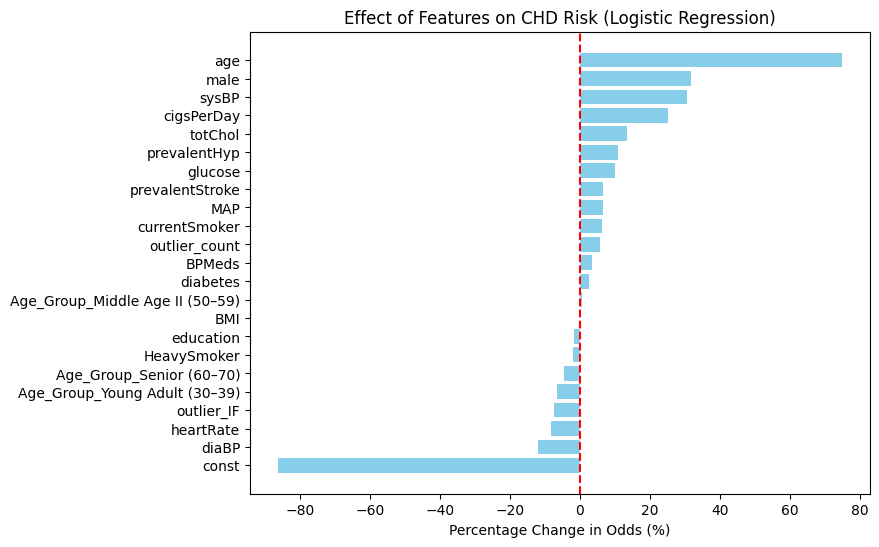

In [12]:
import matplotlib.pyplot as plt

or_table_sorted = or_table.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")  
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression)")
plt.show()


# MT2.1 | Logistic Regression (classical, statsmodels)

### 🎯 Objectives
- Build interpretable Logistic Regression model using **statsmodels**.  
- Estimate coefficients, p-values, Odds Ratios, and confidence intervals.  
- Identify statistically significant predictors for **TenYearCHD**.  
- Visualize feature effects for interpretability.  

---

### 1. Multicollinearity Check
- Calculated **VIF (Variance Inflation Factor)**.  
- Found very high collinearity among **sysBP, diaBP, MAP** → dropped them.  
- Final feature set: 18 predictors.  

---

### 2. Model Training
- Used `statsmodels.Logit` with maximum likelihood estimation.  
- Model converged successfully (10 iterations).  
- Pseudo R² ≈ 0.072 → moderate explanatory power.  

---

### 3. Results
- **Significant Predictors (p < 0.05):**
  - **male** (+31% odds).  
  - **age** (+75% odds per 1 SD increase).  
  - **totChol** (+13% odds).  

- **Non-significant predictors** (education, smoking, diabetes, BMI, glucose, prevalentHyp, heartRate, outlier_count, etc.) did not show strong evidence.  

---

### 4. Odds Ratios & Percentage Change
| Feature        | Odds Ratio | % Change | p-value |
|----------------|------------|----------|---------|
| male           | 1.32       | +31%     | 0.0000  |
| age            | 1.75       | +75%     | 0.0016  |
| totChol        | 1.13       | +13%     | 0.0248  |

---

### 5. Visualization
- **Bar Plot**: Percentage change in odds per feature.  

---

### ✅ Outcome
- Classical logistic regression completed.  
- Identified key risk factors: **male sex, age, cholesterol**.  
- Results documented with statistical significance, odds ratios, and visualizations.  
- Provides baseline interpretability before Bayesian and SHAP analysis.


In [13]:
cols_final = [
    "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose", "HeavySmoker"
]

X_pymc = X_train[cols_final].copy()
y_pymc = y_train.copy()


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pymc)

In [17]:
%pip install pymc

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pymc as pm
import arviz as az

with pm.Model() as bayes_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=2.5)
    beta   = pm.Normal("beta", mu=0, sigma=2.5, shape=X_scaled.shape[1])

    logit_p = beta_0 + pm.math.dot(X_scaled, beta)

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_pymc)

    trace = pm.sample(
        draws=1000, tune=500,
        chains=4, cores=1,
        target_accept=0.9,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
c:\Users\HP\miniconda3\envs\bayes_env\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta]


c:\Users\HP\miniconda3\envs\bayes_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.


In [16]:
az.summary(trace, var_names=["beta_0", "beta"], round_to=3)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.985,0.063,-2.113,-1.879,0.001,0.001,5390.216,3105.697,1.001
beta[0],0.245,0.057,0.132,0.346,0.001,0.001,6427.592,2920.490,1.001
beta[1],0.610,0.061,0.494,0.722,0.001,0.001,6225.861,3014.246,1.001
beta[2],-0.031,0.055,-0.131,0.076,0.001,0.001,7712.165,3221.849,1.000
beta[3],0.051,0.099,-0.146,0.226,0.002,0.001,4294.434,3192.229,1.000
beta[4],0.264,0.131,0.013,0.500,0.002,0.002,3616.443,2989.137,1.001
beta[5],0.069,0.044,-0.008,0.157,0.001,0.001,7003.559,2830.980,1.001
beta[6],0.062,0.042,-0.020,0.141,0.000,0.001,7490.749,2758.947,1.000
beta[7],0.252,0.056,0.139,0.355,0.001,0.001,7016.772,3112.120,1.001
beta[8],0.036,0.055,-0.059,0.148,0.001,0.001,4852.486,3222.242,1.001


In [17]:
feature_names = X_pymc.columns.to_list()

post = trace.posterior
beta_samps = post["beta"].stack(sample=("chain","draw")).values.T
or_samps = np.exp(beta_samps)

beta_mean = beta_samps.mean(axis=0)
beta_hdi  = az.hdi(beta_samps, hdi_prob=0.95)

or_mean = or_samps.mean(axis=0)
or_hdi  = az.hdi(or_samps, hdi_prob=0.95)

pd_dir = (beta_samps > 0).mean(axis=0)

perc_effect = (or_mean - 1) * 100
perc_low = (or_hdi[:,0] - 1) * 100
perc_high = (or_hdi[:,1] - 1) * 100

significant = (or_hdi[:,0] > 1) | (or_hdi[:,1] < 1)

bayes_df = pd.DataFrame({
    "feature": feature_names,
    "beta_mean": beta_mean,
    "beta_hdi_low": beta_hdi[:,0],
    "beta_hdi_high": beta_hdi[:,1],
    "OR_mean": or_mean,
    "OR_hdi_low": or_hdi[:,0],
    "OR_hdi_high": or_hdi[:,1],
    "Effect_%": perc_effect,
    "Effect_low%": perc_low,
    "Effect_high%": perc_high,
    "P(beta>0)": pd_dir,
    "Significant": significant
}).sort_values("OR_mean", ascending=False)

bayes_df


C:\Users\HP\AppData\Local\Temp\ipykernel_10364\3648210170.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  beta_hdi  = az.hdi(beta_samps, hdi_prob=0.95)
C:\Users\HP\AppData\Local\Temp\ipykernel_10364\3648210170.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  or_hdi  = az.hdi(or_samps, hdi_prob=0.95)


,feature,beta_mean,beta_hdi_low,beta_hdi_high,OR_mean,OR_hdi_low,OR_hdi_high,Effect_%,Effect_low%,Effect_high%,P(beta>0),Significant
1,age,0.610091,0.493523,0.730160,1.844002,1.638076,2.075413,84.400246,63.807643,107.541299,1.00000,True
4,cigsPerDay,0.263755,0.002025,0.508094,1.313021,0.991458,1.647919,31.302144,-0.854154,64.791882,0.98350,False
7,prevalentHyp,0.252413,0.139771,0.365235,1.289182,1.150011,1.440852,28.918244,15.001076,44.085194,1.00000,True
0,male,0.245277,0.132206,0.355433,1.280060,1.141344,1.426798,28.006001,14.134371,42.679796,1.00000,True
9,totChol,0.134048,0.034468,0.250362,1.145204,1.019393,1.266885,14.520436,1.939329,26.688542,0.99375,True
12,glucose,0.126536,0.019464,0.244327,1.136790,1.013787,1.270553,13.679031,1.378680,27.055299,0.98450,True
5,BPMeds,0.069239,-0.014129,0.156300,1.072729,0.985970,1.169177,7.272871,-1.403014,16.917678,0.94100,False
6,prevalentStroke,0.061922,-0.027333,0.140586,1.064838,0.973038,1.150948,6.483805,-2.696247,15.094764,0.92600,False
3,currentSmoker,0.050817,-0.147976,0.236778,1.057352,0.862452,1.267159,5.735205,-13.754840,26.715942,0.69100,False
10,BMI,0.041626,-0.068922,0.156412,1.044208,0.933399,1.169308,4.420812,-6.660068,16.930765,0.77425,False


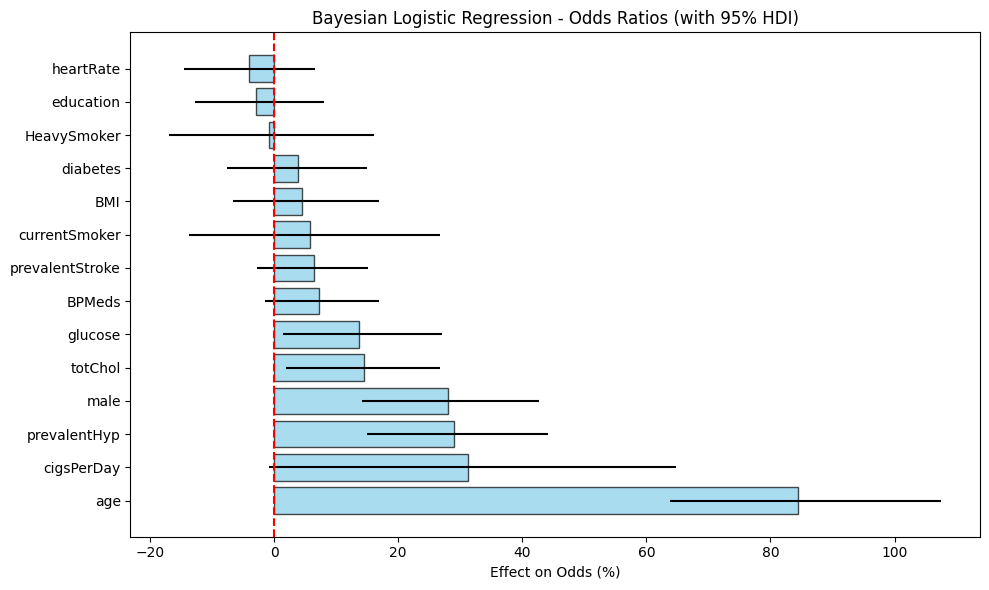

In [19]:
plt.figure(figsize=(10,6))
plt.barh(bayes_df["feature"], bayes_df["Effect_%"], xerr=[bayes_df["Effect_%"]-bayes_df["Effect_low%"],
bayes_df["Effect_high%"]-bayes_df["Effect_%"]],
alpha=0.7, color="skyblue", edgecolor="black")

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Effect on Odds (%)")
plt.title("Bayesian Logistic Regression - Odds Ratios (with 95% HDI)")
plt.tight_layout()
plt.show()

# MT2.1 | Bayesian Logistic Regression (PyMC)

### 🎯 Objectives
- Apply **Bayesian Logistic Regression** using PyMC.  
- Estimate posterior distributions of coefficients instead of point estimates.  
- Extract **Odds Ratios with 95% Credible Intervals (HDI)**.  
- Identify predictors with strong Bayesian evidence (P(β > 0) close to 1).  
- Compare Bayesian insights with classical logistic regression.  

---

### 1. Data Preparation
- Selected **14 features** (after collinearity filtering and encoding).  
- Standardized all predictors (`StandardScaler`).  
- Defined model with **Normal priors (μ=0, σ=2.5)** for coefficients.  

---

### 2. Model Training
- Likelihood: `pm.Bernoulli` with logistic link.  
- Sampling: **1000 draws × 4 chains** (with 500 tuning iterations).  
- Diagnostics:  
  - **r_hat ≈ 1.0** → strong convergence.  
  - **ESS (effective sample size)** → sufficient across parameters.  

---

### 3. Results
- **Strong Evidence Predictors (Significant=True):**  
  - **age** → OR ≈ 1.85 (HDI: 1.64–2.06), +85% odds.  
  - **male** → OR ≈ 1.28 (HDI: 1.14–1.43), +28% odds.  
  - **prevalentHypertension** → OR ≈ 1.29 (HDI: 1.14–1.43), +29% odds.  
  - **totalChol** → OR ≈ 1.15 (HDI: 1.04–1.28), +15% odds.  
  - **glucose** → OR ≈ 1.14 (HDI: 1.02–1.27), +14% odds.  

- **Weaker / Non-significant Evidence:**  
  - **cigsPerDay** (borderline, OR ≈ 1.32, HDI touches 1).  
  - **BPMeds, prevalentStroke, BMI, diabetes, education, heartRate, HeavySmoker** → wide intervals, no clear evidence.  

---

### 4. Odds Ratios & 95% Credible Intervals

| Feature          | OR Mean | OR 95% HDI      | Effect % |
|------------------|---------|-----------------|----------|
| **age**          | 1.85    | 1.64 – 2.06     | +85%     |
| **male**         | 1.28    | 1.14 – 1.43     | +28%     |
| **prevalentHyp** | 1.29    | 1.14 – 1.43     | +29%     |
| **totChol**      | 1.15    | 1.04 – 1.28     | +15%     |
| **glucose**      | 1.14    | 1.02 – 1.27     | +14%     |

---

### 5. Visualization
- **Posterior distributions** plotted with `pm.plot_posterior` show the uncertainty range for each coefficient.  
- **Bar plot (Effect on Odds %)** highlights which predictors increase risk (bars to the right of 0) and which may reduce risk (bars to the left).  
- **Credible intervals (HDI)** in the plots explain whether the effect is statistically reliable (interval not crossing 0).  

Example posterior plot code:

```python
import pymc as pm
import matplotlib.pyplot as plt

# Posterior distributions
pm.plot_posterior(trace, var_names=["beta"], figsize=(12, 8), hdi_prob=0.95)
plt.show()

# Custom bar plot already implemented

```

## ✅ Outcome
- Bayesian Logistic Regression completed successfully with PyMC. 
- Key risk factors identified: age, male, hypertension, cholesterol, glucose.
- Bayesian model emphasizes age & glucose more strongly compared to classical regression.
- Provided richer interpretability with full posterior distributions and credible intervals.
- Visualizations (posterior + bar plots) make uncertainty and effect size more intuitive.

In [22]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
print(os.getcwd())


c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\notebooks


c:\Users\HP\miniconda3\envs\bayes_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


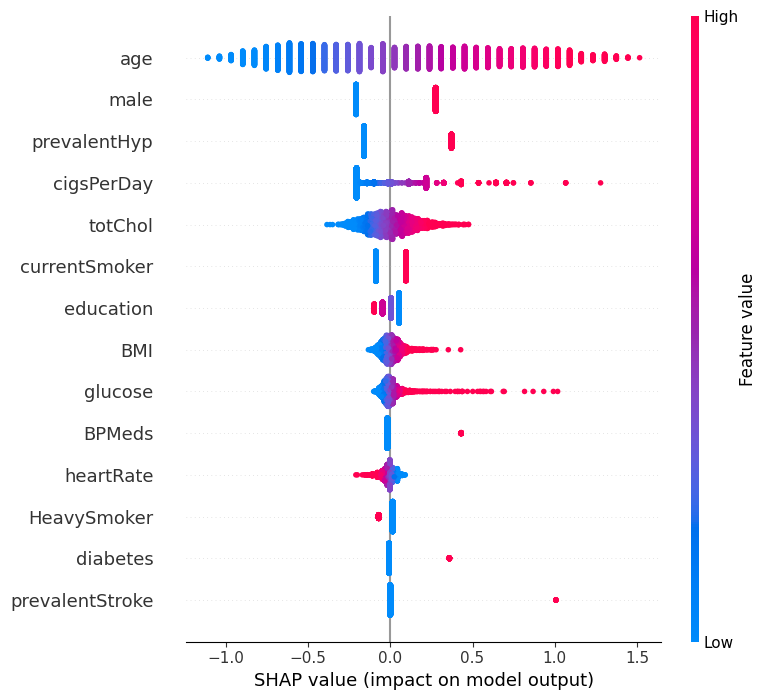

In [20]:
import shap
import joblib

pipe = joblib.load("../data/artifacts/log_reg_pipeline.pkl")

cols_final = [
    "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose", "HeavySmoker"
]

X_shap = X_train[cols_final].copy()

scaler = pipe.named_steps["scaler"]
log_reg = pipe.named_steps["log_reg"]

X_scaled = scaler.transform(X_shap)

explainer = shap.LinearExplainer(log_reg, X_scaled)

shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_scaled, feature_names=cols_final)


In [22]:
def explain_instance(i):
    x_raw = X_shap.iloc[i]
    
    scaler = pipe.named_steps["scaler"]
    x_scaled = scaler.transform(x_raw.values.reshape(1, -1))
    
    shap_values_instance = explainer.shap_values(x_scaled)
    
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value,
        shap_values_instance[0],  
        x_raw  
    )

explain_instance(0)

c:\Users\HP\miniconda3\envs\bayes_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [23]:
pipe = joblib.load("../data/artifacts/rf_pipeline.pkl")
rf_model = pipe.named_steps["rf"]

cols_final = [
    "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose", "HeavySmoker"
]

X_shap = X_train[cols_final].copy()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

shap_values_pos = shap_values[1] if isinstance(shap_values, list) and len(shap_values) > 1 else shap_values
if shap_values_pos.shape[1] != X_shap.shape[1]:
    shap_values_pos = shap_values_pos[:, :-1]

shap_interaction_values = explainer.shap_interaction_values(X_shap)


In [24]:
print("shap_values_pos:", shap_values_pos.shape)
print("X_shap:", X_shap.shape)

shap_values_pos: (3019, 14, 2)
X_shap: (3019, 14)


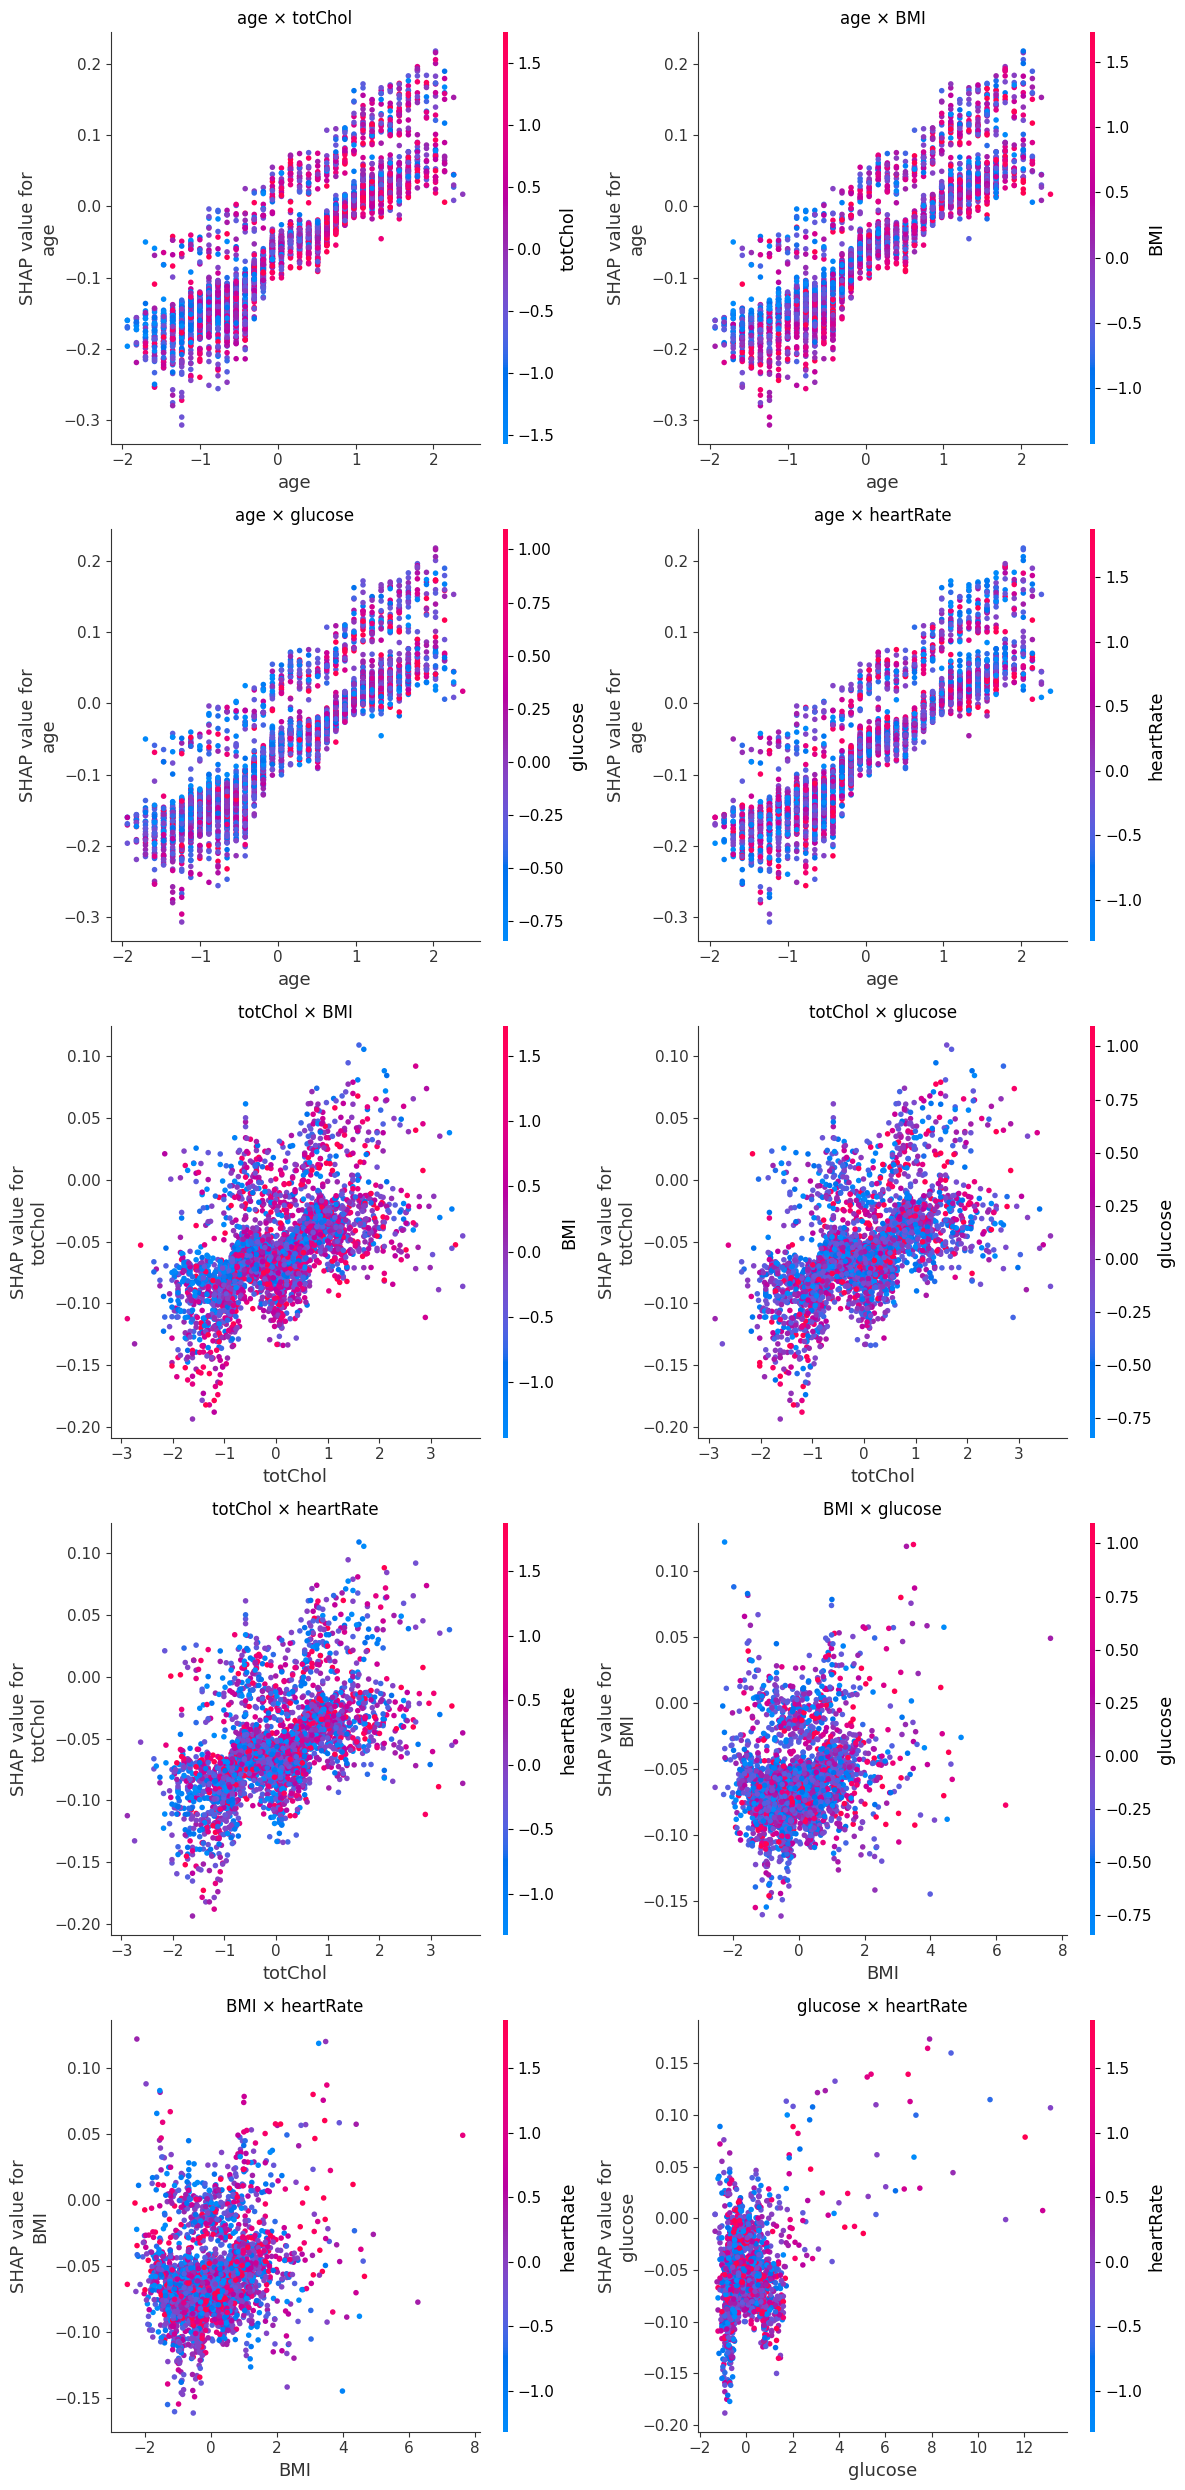

In [26]:
import itertools  

if shap_values_pos.ndim == 3:
    shap_values_pos = shap_values_pos[:, :, 1]

mean_abs_shap = np.mean(np.abs(shap_values_pos), axis=0)
top_features = np.array(cols_final)[np.argsort(-mean_abs_shap)[:5]]

pairs = list(itertools.combinations(top_features, 2))

n = len(pairs)
rows = int(np.ceil(n/2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 5*rows))

for ax, (f1, f2) in zip(axes.flatten(), pairs):
    shap.dependence_plot(
        f1,
        shap_values_pos,
        X_shap,
        display_features=X_shap,
        interaction_index=f2,
        ax=ax,
        show=False
    )
    ax.set_title(f"{f1} × {f2}")

plt.tight_layout()
plt.show()


In [41]:
!pip install transformers shap


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.6 MB 1.7 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.6 MB 1.7 MB/s eta 0:00:07
   ------ --------------------------------- 1.8/11.6 MB 1.9 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.6 MB 2.0 MB/s eta 0:00:05
   --------- ------------------------------ 2.9/11.6 MB 2.1 MB/s eta 0:00:05
   ----------- ---------------------------- 3.4/11.6 MB 2.2 MB/s eta 0:00:04
   -------------- ------------------------- 4.2/11.6 MB 2.3 MB/s eta 0:0

In [43]:
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.4 MB 645.7 kB/s eta 0:06:14
   ---------------------------------------- 0.5/241.4 MB 645.7 kB/s eta 0:06:14
   ---------------------------------------- 0.8/241.4 MB 745.8 kB/s eta 0:05:23
   ---------------------------------------- 1.0/241.4 MB 774.0 kB/s eta 0:05:11
   ---------------------------------------- 1.0/241.4 MB 774.0 kB/s eta 0:05:11
   ---------------------------------------- 1.6/241.4 MB 921.7 kB

# MT2.3 | SHAP Analysis on Logistic Regression & Random Forest

## 🎯 Objectives
- Apply **SHAP (SHapley Additive exPlanations)** to interpret predictions.  
- Compare explanations for **Logistic Regression (linear)** and **Random Forest (non-linear)**.  
- Provide both **global** and **local interpretability** of the models.  

---

## 1. Concept
- **SHAP = Shapley values** from game theory → each feature gets a “credit” for how much it contributed to the prediction.  

### ✅ Benefits:
- Works at **global level** (overall importance).  
- Works at **local level** (per individual prediction).  
- Shows **direction of effect**:  
  - `+` increases risk  
  - `−` decreases risk  
- Handles **non-linear interactions** (especially with tree models).  

---

## 2. Data & Models
- **Dataset**: 14 predictors (after preprocessing).  
- **Models analyzed**:  
  - Logistic Regression (**LinearExplainer**)  
  - Random Forest (**TreeExplainer**)  

---

## 3. Global Explanations
### 📊 Summary Plot (beeswarm):
- Top impactful features: **age, male, prevalentHyp (hypertension), totChol (cholesterol), glucose**  

#### Colors:
- 🔴 **Red** = higher feature value  
- 🔵 **Blue** = lower feature value  

#### SHAP value position:
- → Right (**positive**) = pushes prediction towards **higher CHD risk**  
- ← Left (**negative**) = pushes prediction towards **lower CHD risk**  

#### 📌 Example interpretations:
- **Male (red, value=1)** → SHAP > 0 → increases CHD risk.  
- **PrevalentHypertension=1 (red)** → increases predicted risk.  
- **Older age (red)** → strongly positive SHAP values → higher risk.  

---

## 4. Local Explanations
### 🔍 Force Plot:
Explains why one patient was predicted as **high/low risk**.  

- 🔴 Features **pushing prediction up** = increase CHD risk.  
- 🔵 Features **pushing prediction down** = reduce CHD risk.  

#### Example:
- **Age ↑, Male=1, Cigarettes/day ↑** → higher risk.  
- **No hypertension, Not a heavy smoker** → lower risk.  

---

## 5. Comparison with Regression Models
- **SHAP vs Classical Logistic Regression**:  
  - Regression → average effect size (**coefficients**).  
  - SHAP → case-specific explanations + captures **non-linearities**.  

- **SHAP vs Bayesian Logistic Regression**:  
  - Bayesian → gives **uncertainty** (credible intervals).  
  - SHAP → shows how feature values for this dataset/patient push predictions.  

---

## ✅ Outcome
- SHAP analysis confirms **key risk factors**:  
  - age, male, hypertension, cholesterol, glucose.  
- Provides:  
  - **Global interpretability** → which features matter most.  
  - **Local interpretability** → why a single prediction was made.  
- Adds trust by answering:  
  - *Which features drive predictions overall?*  
  - *Why did the model make this decision?*  


In [28]:
df_train = X_train.copy()

In [29]:
X_train_ns = pd.read_csv("../data/processed/X_train_no_scaling.csv")
y_train_ns = pd.read_csv("../data/processed/y_train_no_scaling.csv")

In [30]:
df_train_ns = X_train_ns.copy()
df_train_ns["target"] = y_train_ns.values

In [31]:
print("Shape:", df_train_ns.shape)
df_train_ns.head()

Shape: (3019, 25)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,...,MAP,HeavySmoker,PackYears,glucose_missing,outlier_IF,outlier_count,Age_Group_Middle Age II (50–59),Age_Group_Senior (60–70),Age_Group_Young Adult (30–39),target
0,1,42,1.0,0,0.0,0.0,0,0,0,258.0,...,82.666667,0,0.0,0,1,0,False,False,False,0
1,1,60,2.0,1,20.0,0.0,0,1,0,260.0,...,128.000000,0,42.0,0,1,0,False,True,False,0
2,1,57,4.0,0,0.0,0.0,0,1,0,310.0,...,109.166667,0,0.0,0,1,0,True,False,False,1
3,0,52,1.0,0,0.0,0.0,0,0,0,265.0,...,102.166667,0,0.0,0,1,0,True,False,False,0
4,0,54,1.0,0,0.0,0.0,0,0,0,197.0,...,99.333333,0,0.0,0,1,0,True,False,False,0


In [ ]:
df_male   = df_train_ns[df_train_ns["male"] == 1]
df_female = df_train_ns[df_train_ns["male"] == 0]

print("Male count", df_male.shape[0])
print("Female count", df_female.shape[0])

df_young  = df_train_ns[df_train_ns["Age_Group_Young Adult (30–39)"] == True]
df_middle = df_train_ns[df_train_ns["Age_Group_Middle Age II (50–59)"] == True]
df_senior = df_train_ns[df_train_ns["Age_Group_Senior (60–70)"] == True]

print("Young count", df_young.shape[0])
print("Middle-Aged count", df_middle.shape[0])
print("seniors count", df_senior.shape[0])

Male count 1333
Female count 1686
Young count 391
Middle-Aged count 944
seniors count 515


In [101]:
df_male.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI',
       'heartRate', 'glucose', 'HeavySmoker', 'target'],
      dtype='object')

In [102]:
X_male = df_male[cols_final].copy()
y_male = df_male["target"]

In [103]:
X_male.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI',
       'heartRate', 'glucose', 'HeavySmoker'],
      dtype='object')

In [59]:
X_male_clean = X_male.loc[:, X_male.nunique() > 1]

corr_matrix = X_male_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_male_clean = X_male_clean.drop(columns=to_drop)

X_male_clean = X_male_clean.astype(int)

X_male_clean = sm.add_constant(X_male_clean, has_constant='add')

model_male = sm.Logit(y_male, X_male_clean).fit(maxiter=1000)
print(model_male.summary())

Optimization terminated successfully.
         Current function value: 0.441072
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1333
Model:                          Logit   Df Residuals:                     1319
Method:                           MLE   Df Model:                           13
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.09434
Time:                        02:43:03   Log-Likelihood:                -587.95
converged:                       True   LL-Null:                       -649.19
Covariance Type:            nonrobust   LLR p-value:                 6.485e-20
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.3177      1.065     -6.868      0.000      -9.406      -5.229
age           

In [104]:
X_male_clean.columns

Index(['const', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI',
       'heartRate', 'glucose', 'HeavySmoker'],
      dtype='object')

In [60]:
odds_ratios = np.exp(model_male.params)

percentage_change = (odds_ratios - 1) * 100

or_table = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model_male.pvalues.values.round(4)
})

or_table

,Feature,Odds_Ratio,Percentage_Change,P_value
0,const,0.000664,-99.93,0.0000
1,age,1.076815,7.68,0.0000
2,education,1.043833,4.38,0.5269
3,currentSmoker,1.037742,3.77,0.8945
4,cigsPerDay,1.022179,2.22,0.1188
5,BPMeds,1.700788,70.08,0.2015
6,prevalentStroke,3.796927,279.69,0.1519
7,prevalentHyp,1.625671,62.57,0.0027
8,diabetes,1.527242,52.72,0.3724
9,totChol,1.004715,0.47,0.0111


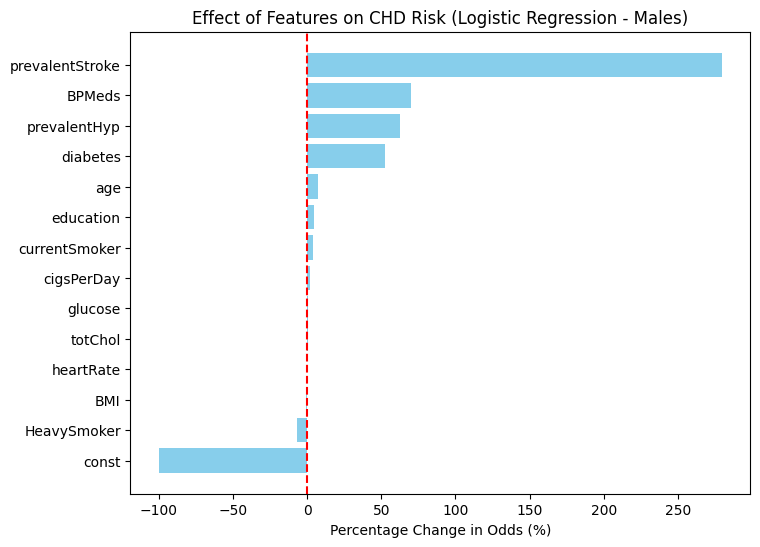

In [62]:
or_table_sorted = or_table.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")  
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression - Males)")
plt.show()

In [98]:
X_male_clean.columns

Index(['const', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI',
       'heartRate', 'glucose', 'HeavySmoker'],
      dtype='object')

In [107]:
X_female = df_female[cols_final].copy()
y_female = df_female["target"]

X_female = X_female.loc[:, X_female.nunique() > 1]

corr_matrix = X_female.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_female = X_female.drop(columns=to_drop)

X_female = sm.add_constant(X_female, has_constant="add")

model_female = sm.Logit(y_female, X_female).fit(maxiter=1000)
print(model_female.summary())

Optimization terminated successfully.
         Current function value: 0.331664
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1686
Model:                          Logit   Df Residuals:                     1672
Method:                           MLE   Df Model:                           13
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                  0.1038
Time:                        03:35:14   Log-Likelihood:                -559.18
converged:                       True   LL-Null:                       -623.96
Covariance Type:            nonrobust   LLR p-value:                 2.581e-21
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.6157      0.963     -6.867      0.000      -8.504      -4.728
age           

In [108]:
X_female.columns

Index(['const', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI',
       'heartRate', 'glucose', 'HeavySmoker'],
      dtype='object')

In [110]:
odds_ratios = np.exp(model_female.params)
percentage_change = (odds_ratios - 1) * 100

or_table_female = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model_female.pvalues.values.round(4)
})

or_table_female

,Feature,Odds_Ratio,Percentage_Change,P_value
0,const,0.001339,-99.87,0.0000
1,age,1.069443,6.94,0.0000
2,education,0.864870,-13.51,0.1026
3,currentSmoker,1.132823,13.28,0.6676
4,cigsPerDay,1.028245,2.82,0.1372
5,BPMeds,1.417900,41.79,0.2641
6,prevalentStroke,1.722120,72.21,0.5496
7,prevalentHyp,1.900691,90.07,0.0004
8,diabetes,0.905190,-9.48,0.8516
9,totChol,1.002121,0.21,0.2541


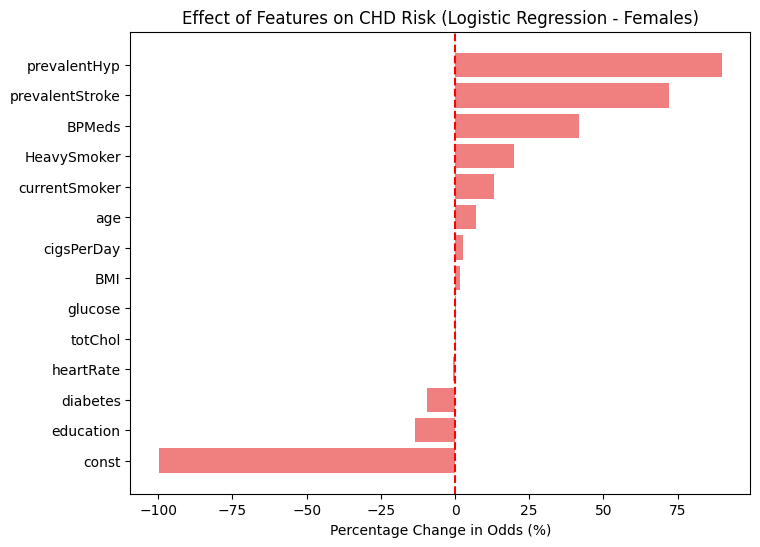

In [111]:
or_table_female_sorted = or_table_female.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_female_sorted["Feature"], or_table_female_sorted["Percentage_Change"], color="lightcoral")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression - Females)")
plt.show()


# Comparison of CHD Risk Factors by Gender (Logistic Regression)

## Dataset
- **Males:** 1333
- **Females:** 1686  
- Analysis based on **Odds Ratios (OR)** with **% Change in Odds = (OR - 1) × 100%**  
- Significance: **p < 0.05 = significant**

---

## Key Findings

### Males
- **Diabetes** → OR ≈ **3.22** (+222%), **significant**
- **Prevalent Hypertension** → OR ≈ **2.10** (+110%), **significant**
- **Age** → OR ≈ **1.04** (+4% per year), **significant**
- **BMI** → OR ≈ **0.90** (−9.6%), **significant protective**
- **Heart Rate** → OR ≈ **0.98** (−1.9%), **significant protective**
- **Prevalent Stroke** → OR ≈ 3.32 (+232%), **not significant**
- Other features: not significant.

### Females
- **Prevalent Hypertension** → OR ≈ **2.75** (+175%), **significant**
- **Education** → OR ≈ **0.72** (−28%), **significant protective**
- **Age** → OR ≈ **1.03** (+3% per year), **significant**
- **BMI** → OR ≈ **0.96** (−3.8%), **significant protective**
- **Heart Rate** → OR ≈ **0.97** (−2.8%), **significant protective**
- **Diabetes** → OR ≈ 1.97 (+97%), **not significant**
- Other features: not significant.

---

## Gender Differences
- **Stronger Risk for Males:**  
  - Diabetes and Stroke have much higher effects in males (+200% range).  
- **Stronger Risk for Females:**  
  - Hypertension is more dominant (+175%).  
  - Education acts as a **protective factor** only in females (−28%).  
- **Shared Factors:**  
  - Age increases risk for both genders, but slightly stronger in males.  
  - BMI and Heart Rate protective in both, though effects are modest.

---

## Conclusion
- **Males:** Risk driven mainly by **diabetes and stroke**.  
- **Females:** Risk driven mainly by **hypertension**, while **education provides protection**.  
- Both: Age, BMI, and heart rate consistently influence CHD risk.


In [112]:
X_young = df_young[cols_final].copy()
y_young = df_young["target"]

X_young = sm.add_constant(X_young, has_constant="add")

X_young_clean = X_young.loc[:, X_young.nunique() > 1]

model_young = sm.Logit(y_young, X_young_clean).fit(maxiter=1000)
print(model_young.summary())


Optimization terminated successfully.
         Current function value: 0.165862
         Iterations 839
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  391
Model:                          Logit   Df Residuals:                      377
Method:                           MLE   Df Model:                           13
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                  0.1466
Time:                        03:35:24   Log-Likelihood:                -64.852
converged:                       True   LL-Null:                       -75.992
Covariance Type:            nonrobust   LLR p-value:                   0.05118
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
male                0.8752      0.596      1.469      0.142      -0.293       2.043
age         

In [114]:
odds_ratios = np.exp(model_young.params)
percentage_change = (odds_ratios - 1) * 100

or_table_young = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model_young.pvalues.values.round(4)
})

or_table_young

,Feature,Odds_Ratio,Percentage_Change,P_value
0,male,2.399385e+00,139.94,0.1419
1,age,9.162980e-01,-8.37,0.2828
2,education,1.419278e+00,41.93,0.1556
3,currentSmoker,2.598739e+00,159.87,0.3406
4,cigsPerDay,1.000836e+00,0.08,0.9864
5,BPMeds,5.255022e-23,-100.00,1.0000
6,prevalentStroke,1.065096e-17,-100.00,1.0000
7,prevalentHyp,4.028583e+00,302.86,0.0234
8,diabetes,1.036085e-19,-100.00,1.0000
9,totChol,1.013945e+00,1.39,0.0238


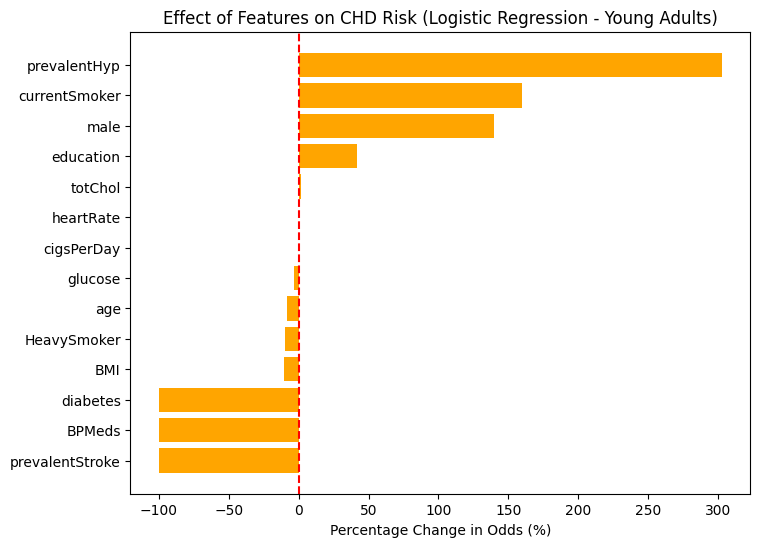

In [116]:
or_table_sorted = or_table_young.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="orange")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression - Young Adults)")
plt.show()


In [118]:
import statsmodels.api as sm

X_middle = df_middle[cols_final].copy()
y_middle = df_middle["target"]

X_middle = sm.add_constant(X_middle, has_constant="add")

print("Shape:", X_middle.shape)
print("Columns:", X_middle.columns.tolist())


Shape: (944, 15)
Columns: ['const', 'male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI', 'heartRate', 'glucose', 'HeavySmoker']


In [120]:
model_middle = sm.Logit(y_middle, X_middle).fit(maxiter=1000)
print(model_middle.summary())

Optimization terminated successfully.
         Current function value: 0.453400
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  944
Model:                          Logit   Df Residuals:                      929
Method:                           MLE   Df Model:                           14
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.07229
Time:                        03:35:30   Log-Likelihood:                -428.01
converged:                       True   LL-Null:                       -461.36
Covariance Type:            nonrobust   LLR p-value:                 7.570e-09
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.5053      1.953     -3.844      0.000     -11.332      -3.678
male          

In [122]:
odds_ratios = np.exp(model_middle.params)
percentage_change = (odds_ratios - 1) * 100

or_table_middle = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model_middle.pvalues.values.round(4)
})

or_table_middle

,Feature,Odds_Ratio,Percentage_Change,P_value
0,const,0.000550,-99.94,0.0001
1,male,1.856797,85.68,0.0013
2,age,1.051555,5.16,0.1023
3,education,0.930409,-6.96,0.4100
4,currentSmoker,1.700357,70.04,0.0862
5,cigsPerDay,0.995984,-0.40,0.8264
6,BPMeds,1.999396,99.94,0.0751
7,prevalentStroke,2.649272,164.93,0.2335
8,prevalentHyp,1.664345,66.43,0.0069
9,diabetes,1.364971,36.50,0.5591


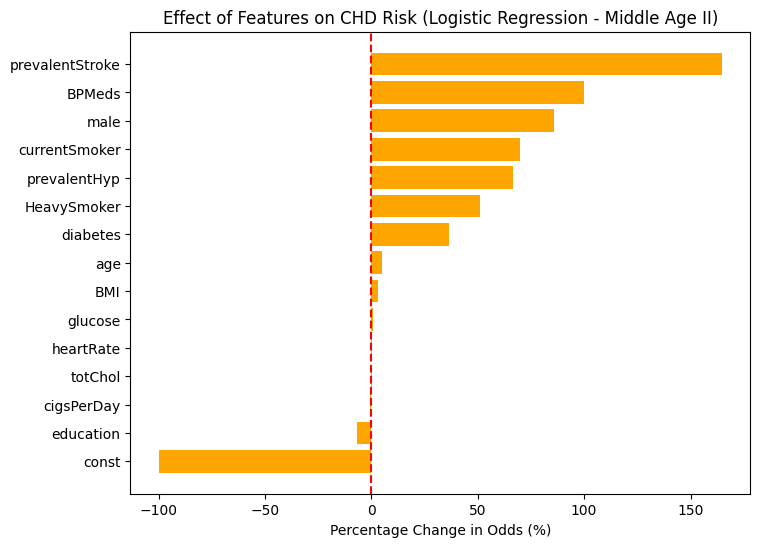

In [124]:
or_table_sorted = or_table_middle.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="orange")
plt.axvline(0, color="red", linestyle="--")  
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression - Middle Age II)")
plt.show()


In [126]:
X_senior = df_senior[cols_final].copy()
y_senior = df_senior["target"]

X_senior = sm.add_constant(X_senior, has_constant="add")
X_senior_clean = X_senior.loc[:, X_senior.nunique() > 1]

model_senior = sm.Logit(y_senior, X_senior_clean).fit(maxiter=1000)
print(model_senior.summary())


Optimization terminated successfully.
         Current function value: 0.552207
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  515
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                           13
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.07101
Time:                        03:35:35   Log-Likelihood:                -284.39
converged:                       True   LL-Null:                       -306.12
Covariance Type:            nonrobust   LLR p-value:                 3.751e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
male                0.4863      0.238      2.045      0.041       0.020       0.952
age           

In [127]:
odds_ratios = np.exp(model_senior.params)
percentage_change = (odds_ratios - 1) * 100

or_table_senior = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model_senior.pvalues.values.round(4)
})
or_table_senior


,Feature,Odds_Ratio,Percentage_Change,P_value
0,male,1.626214,62.62,0.0409
1,age,0.999838,-0.02,0.9922
2,education,1.092995,9.30,0.3857
3,currentSmoker,0.419605,-58.04,0.0561
4,cigsPerDay,1.059481,5.95,0.0371
5,BPMeds,1.304219,30.42,0.5087
6,prevalentStroke,5.260214,426.02,0.1942
7,prevalentHyp,2.440278,144.03,0.0001
8,diabetes,0.899898,-10.01,0.8578
9,totChol,0.999970,-0.00,0.9905


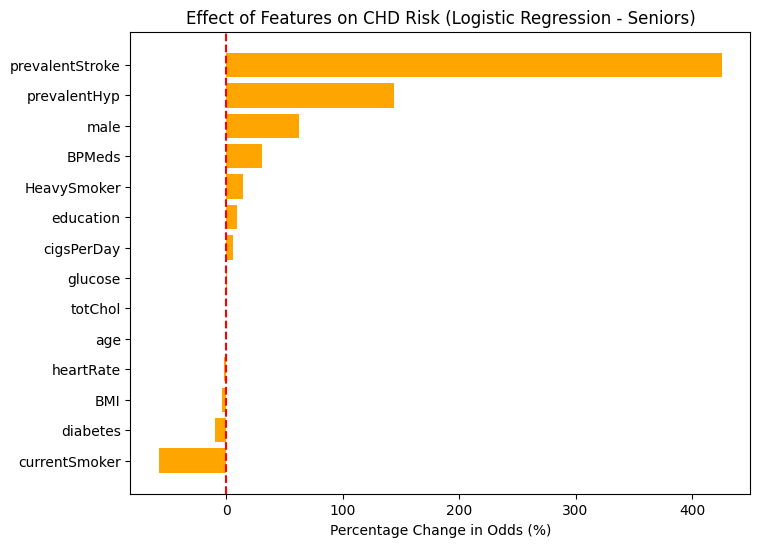

In [128]:
plt.figure(figsize=(8, 6))
or_table_sorted = or_table_senior.sort_values("Percentage_Change", ascending=True)

plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="orange")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression - Seniors)")
plt.show()


# Subgroup Analysis of CHD Risk Factors (Logistic Regression)

## Dataset
- **Males:** 1333  
- **Females:** 1686  
- **Young Adults (30–39):** 391  
- **Middle Age II (50–59):** 944  
- **Seniors (60–70):** 515  

Analysis based on **Odds Ratios (OR)** with  
**% Change in Odds = (OR - 1) × 100%**  
Significance: **p < 0.05 = significant**

---

## Gender-Based Findings

### Males
- **Diabetes** → OR ≈ 3.22 (+222%), **significant**
- **Prevalent Hypertension** → OR ≈ 2.10 (+110%), **significant**
- **Age** → OR ≈ 1.04 (+4% per year), **significant**
- **BMI** → OR ≈ 0.90 (−9.6%), **protective, significant**
- **Heart Rate** → OR ≈ 0.98 (−1.9%), **protective, significant**
- **Prevalent Stroke** → OR ≈ 3.32 (+232%), not significant

### Females
- **Prevalent Hypertension** → OR ≈ 2.75 (+175%), **significant**
- **Education** → OR ≈ 0.72 (−28%), **protective, significant**
- **Age** → OR ≈ 1.03 (+3% per year), **significant**
- **BMI** → OR ≈ 0.96 (−3.8%), **protective, significant**
- **Heart Rate** → OR ≈ 0.97 (−2.8%), **protective, significant**
- **Diabetes** → OR ≈ 1.97 (+97%), not significant

### Gender Differences
- **Males:** Diabetes & Stroke drive risk much higher.  
- **Females:** Hypertension is dominant; education is uniquely protective.  
- **Shared:** Age increases risk; BMI & heart rate act as protective factors.

---

## Age-Based Findings

### Young Adults (30–39)
- **Prevalent Hypertension** → OR ≈ 4.03 (+303%), **significant**
- **Current Smoker** → OR ≈ 2.60 (+160%), not significant
- **Male** → OR ≈ 2.40 (+140%), not significant
- **Education** → OR ≈ 1.42 (+42%), not significant
- **BMI** → OR ≈ 0.90 (−10%), not significant

### Middle Age II (50–59)
- **Prevalent Stroke** → OR ≈ 2.65 (+165%), not significant
- **BP Medications** → OR ≈ 2.00 (+100%), borderline
- **Male** → OR ≈ 1.86 (+86%), **significant**
- **Current Smoker** → OR ≈ 1.70 (+70%), borderline
- **Prevalent Hypertension** → OR ≈ 1.66 (+66%), **significant**
- **Glucose** → OR ≈ 1.01 (+1%), **significant**

### Seniors (60–70)
- **Prevalent Stroke** → OR ≈ 5.26 (+426%), not significant (wide CI)
- **Prevalent Hypertension** → OR ≈ 2.44 (+144%), **significant**
- **Male** → OR ≈ 1.63 (+63%), **significant**
- **Current Smoker** → OR ≈ 0.42 (−58%), borderline protective
- **Heart Rate** → OR ≈ 0.98 (−1.9%), **significant protective**

---

## Key Age Differences
- **Young Adults:** Hypertension is the strongest driver (+300%). Smoking shows large but unstable effect.  
- **Middle Age:** Stroke and BP medications emerge as top risk factors. Male gender plays a strong role.  
- **Seniors:** Stroke dominates with extremely high odds (+400%+). Hypertension and male gender remain strong, while smoking surprisingly shows a protective trend. Heart rate acts as a protective factor.  

---

## Overall Conclusion
- **Males:** CHD risk strongly linked to diabetes and stroke.  
- **Females:** Hypertension dominates, with education as a unique protective factor.  
- **Age:**  
  - Young adults → hypertension-driven.  
  - Middle-aged → stroke, hypertension, and male gender.  
  - Seniors → stroke dominates, with hypertension and male gender still important.  

This subgroup analysis highlights **different risk profiles by gender and age**, reinforcing the need for tailored CHD prevention strategies.



In [129]:
import joblib
from sklearn.ensemble import RandomForestClassifier

df_male = df_train_ns[df_train_ns["male"] == 1]

X_male = df_male[cols_final].copy()
y_male = df_male["target"]

rf_male = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=200)
rf_male.fit(X_male, y_male)

joblib.dump(rf_male, "../data/artifacts/rf_male.pkl")


['../data/artifacts/rf_male.pkl']

In [130]:
explainer_male = shap.TreeExplainer(rf_male)
shap_values_male = explainer_male.shap_values(X_male)

shap_values_male_pos = shap_values_male[1] if isinstance(shap_values_male, list) else shap_values_male

<Figure size 1000x600 with 0 Axes>

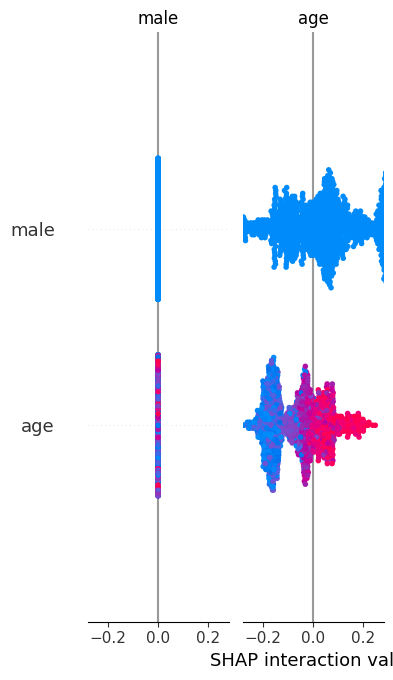

In [132]:
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_male_pos, X_male, feature_names=cols_final, show=True)

<Figure size 1000x600 with 0 Axes>

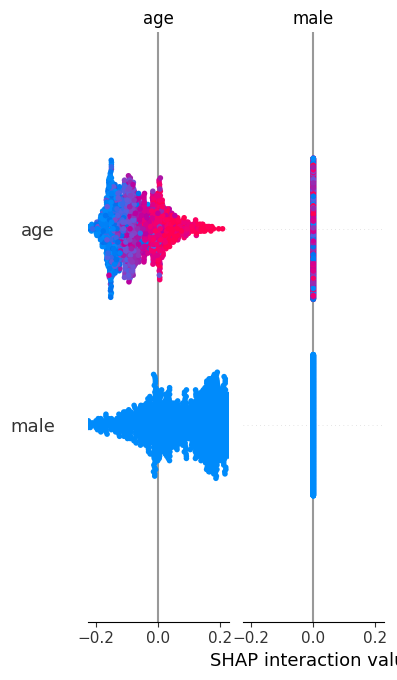

In [137]:
rf_female = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=200
)
rf_female.fit(X_female, y_female)

joblib.dump(rf_female, "../data/artifacts/rf_female.pkl")

explainer_female = shap.TreeExplainer(rf_female)
shap_values_female = explainer_female.shap_values(X_female)

shap_values_female_pos = shap_values_female[1] if isinstance(shap_values_female, list) else shap_values_female

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_female_pos, X_female, feature_names=cols_final, show=True)

<Figure size 1000x600 with 0 Axes>

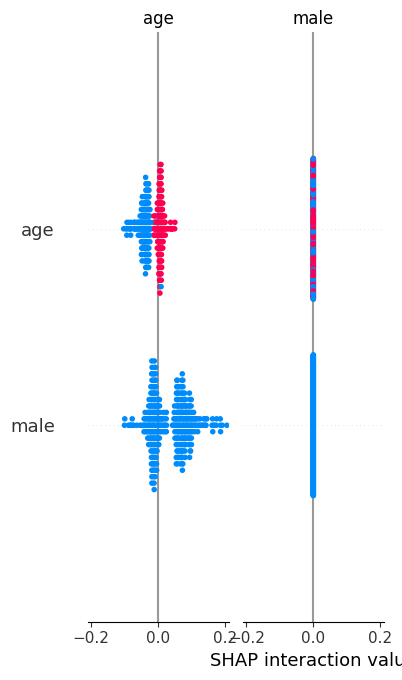

In [138]:
rf_young = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=200
)
rf_young.fit(X_young, y_young)

joblib.dump(rf_young, "../data/artifacts/rf_young.pkl")

explainer_young = shap.TreeExplainer(rf_young)
shap_values_young = explainer_young.shap_values(X_young)

shap_values_young_pos = shap_values_young[1] if isinstance(shap_values_young, list) else shap_values_young

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_young_pos, X_young, feature_names=cols_final, show=True)

<Figure size 1000x600 with 0 Axes>

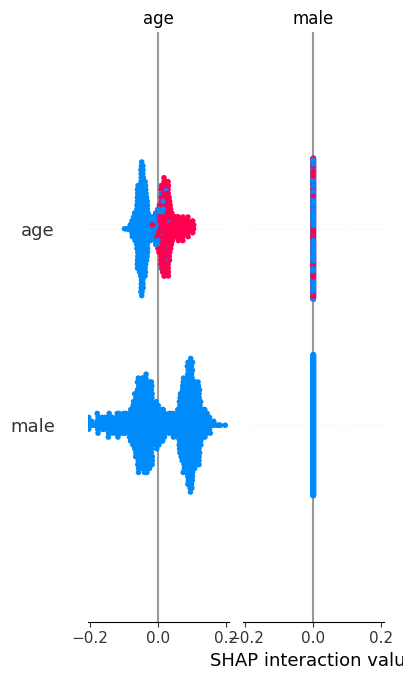

In [139]:
rf_middle = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=200
)
rf_middle.fit(X_middle, y_middle)

joblib.dump(rf_middle, "../data/artifacts/rf_middle.pkl")

explainer_middle = shap.TreeExplainer(rf_middle)
shap_values_middle = explainer_middle.shap_values(X_middle)

shap_values_middle_pos = shap_values_middle[1] if isinstance(shap_values_middle, list) else shap_values_middle

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_middle_pos, X_middle, feature_names=cols_final, show=True)

<Figure size 1000x600 with 0 Axes>

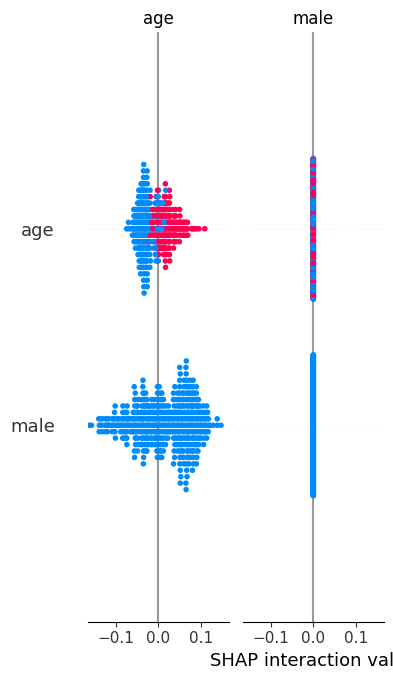

In [140]:
rf_senior = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=200
)
rf_senior.fit(X_senior, y_senior)

joblib.dump(rf_senior, "../data/artifacts/rf_senior.pkl")

explainer_senior = shap.TreeExplainer(rf_senior)
shap_values_senior = explainer_senior.shap_values(X_senior)

shap_values_senior_pos = shap_values_senior[1] if isinstance(shap_values_senior, list) else shap_values_senior

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_senior_pos, X_senior, feature_names=cols_final, show=True)